In [1]:
import os
import tifffile as tiff,io
import numpy as np
from PIL import Image
import mmcv
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def extract_patches(image, label,sam, patch_size=(64, 64, 40), stride=(64, 64, 40)):
    H, W, C = patch_size
    img_h, img_w, img_c = image.shape

    patches = []
    for z in range(0, img_c - C + 1, stride[2]):
        print("z = ",z)
        for y in range(0, img_h - H + 1, stride[0]):
            for x in range(0, img_w - W + 1, stride[1]):
                img_patch = image[y:y+H, x:x+W, z:z+C]
                lbl_patch = label[y:y+H, x:x+W, z:z+C] * 255
                sam_patch = sam[y:y+H, x:x+W, z:z+C] * 255

                # Discard if patch is constant
                if len(np.unique(img_patch)) == 1:
                    continue

                # Discard if ≥99% voxels are white (255)
                white_ratio = np.mean(img_patch == 255)
                if white_ratio >= 0.99:
                    continue

                patches.append((img_patch, lbl_patch,sam_patch, (x, y, z)))
    return patches


def save_sam2_patches(patches, out_dir, save_tiff=True):
    os.makedirs(out_dir, exist_ok=True)

    for i, (img_patch, lbl_patch,sam_patch, pos) in enumerate(patches):

        # patch_dir = os.path.join(out_dir, f"patch_{i:04d}")
        # os.makedirs(patch_dir, exist_ok=True)

        # # Save each slice of the image patch as PNG (for SAM2 frames)
        # for c in range(img_patch.shape[2]):
        #     frame = img_patch[:, :, c]
        #     frame_img = Image.fromarray(frame.astype(np.uint8))
        #     frame_img.save(os.path.join(patch_dir, f"{c:04d}.jpg"))

        # Save label patch as TIFF (optional)
        if save_tiff:

            tif_label= os.path.join(out_dir,"labels")
            os.makedirs(tif_label, exist_ok=True)
            tiff.imwrite(os.path.join(tif_label, f"patch_{i:04d}.tif"), lbl_patch.astype(np.uint8))

            tif_sam= os.path.join(out_dir,"sam")
            os.makedirs(tif_sam, exist_ok=True)
            tiff.imwrite(os.path.join(tif_sam, f"patch_{i:04d}.tif"), sam_patch.astype(np.uint8))

            tif_images= os.path.join(out_dir,"images")
            os.makedirs(tif_images, exist_ok=True)
            tiff.imwrite(os.path.join(tif_images, f"patch_{i:04d}.tif"), img_patch.astype(np.uint8))


In [48]:
image_path = "/home/sow/3D_data/i3.tiff"
label_path = "/home/sow/3D_data/mask_i3.tiff"
sam_path = "/home/sow/3D_data/pred_sam_i3.tiff"
out_dir = "data/I3/patches_dataset"

# Load the 3D TIFF stacks
image = tiff.imread(image_path)  # shape (H, W, Z)
label = tiff.imread(label_path)  # shape (H, W, Z)
sam = tiff.imread(sam_path).astype(label.dtype)

# Reorder to (Y, X, Z) so depth is last
image = np.transpose(image, (1, 2, 0))  # (1710, 2580, 500)
label = np.transpose(label, (1, 2, 0))
sam = np.transpose(sam,(1, 2, 0))

# Ensure shape consistency
assert image.shape == label.shape, "Image and label must have the same shape!"

# Extract patches
patches = extract_patches(image, label,sam, patch_size=(256, 256, 40))

# Save them
save_sam2_patches(patches, out_dir)

z =  0
z =  40
z =  80
z =  120
z =  160
z =  200
z =  240
z =  280
z =  320
z =  360
z =  400
z =  440


In [20]:
sam.dtype

dtype('uint8')

In [2]:
client = mmcv.FileClient()
byte = client.get("data/LW4/patch_dataset/images/patch_0000.tif")
with tiff.TiffFile(io.BytesIO(byte)) as tif:
    v = tif.asarray()[None]

In [3]:
a = mmcv.imfrombytes(byte,backend='tifffile')

In [4]:
v.shape

(1, 40, 256, 256)

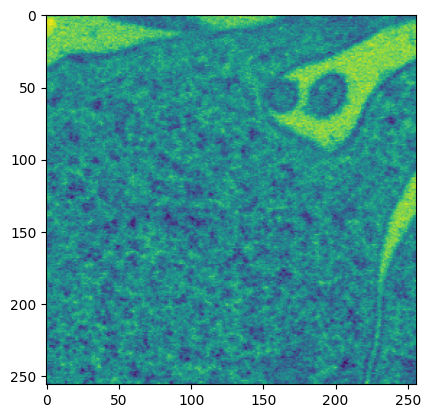

In [28]:
plt.imshow(v.squeeze()[0])

In [30]:
v1 = F.interpolate(torch.from_numpy(v).unsqueeze(0).to(torch.float32),scale_factor=(1,0.25,0.25),mode="trilinear",align_corners=False).squeeze(0)

/home/sow/venv/prism-uda/lib/python3.8/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


In [31]:
v1.shape

torch.Size([1, 40, 64, 64])

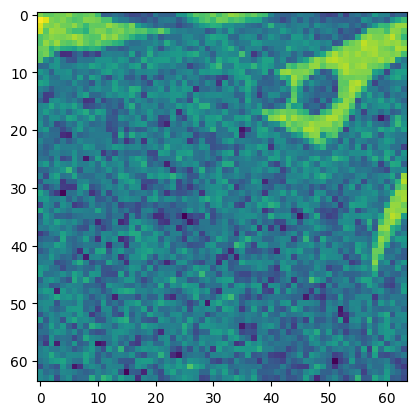

In [32]:
plt.imshow(v1.squeeze()[-0])

In [33]:
v1.shape

torch.Size([1, 40, 64, 64])

In [40]:
a = np.pad(v1.numpy(),pad_width=((0,0),(0,0),(0,64),(0,64)),mode="constant",constant_values="0")

In [46]:
a[None,:,:,None,...].shape

(1, 1, 40, 1, 128, 128)

In [41]:
a.shape

(1, 40, 128, 128)

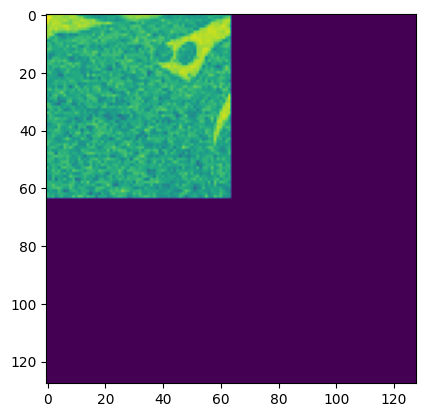

In [43]:
plt.imshow(a.squeeze()[0])

In [59]:
patches[0][0].shape

(64, 64, 40)

In [47]:
len(patches)

7890

In [31]:
def convert_to_train_id(file, is_pseudo=False):
    # Re-assign labels to match the format of Cityscapes
    pil_label = tiff.imread(file)
    label = np.asarray(pil_label)
    id_to_trainid = {
        0: 0,
        255: 1,
    }
    label_copy = 255 * np.ones(label.shape, dtype=np.uint8)
    sample_class_stats = {}
    for k, v in id_to_trainid.items():
        k_mask = label == k
        label_copy[k_mask] = v
        n = int(np.sum(k_mask))
        if n > 0:
            sample_class_stats[v] = n
    new_suffix = '_pseudoTrainIds.tif' if is_pseudo else '_labelTrainIds.tif'
    new_file = file.replace('.tif', new_suffix)
    assert file != new_file
    sample_class_stats['file'] = new_file
    tiff.imwrite(new_file,label_copy.astype(np.uint8))

In [32]:
convert_to_train_id("patch_0001.tif")